#### Relationship between density and diameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
d = np.linspace(0, 1, 100)
rho = d*(2*(np.sqrt(2)+1) - (np.sqrt(2)+1)**2*d)

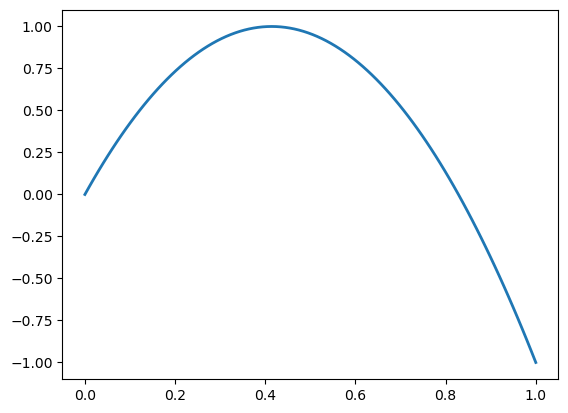

In [2]:
fig, ax = plt.subplots()

ax.plot(d, rho, linewidth=2.0)

plt.show()

In [3]:
# quadratic root formula
def getLeftRoot(a, b, c):
    delta = np.power(b,2)-4*a*c
    if delta < 0: 
        raise ValueError('No Left Real Root Exits')
    else:
        res = np.min(((-b+np.sqrt(delta)) / (2*a),(-b-np.sqrt(delta)) / (2*a)))
        return(res)

In [4]:
#  check max d
rho_max = 0
d_max = getLeftRoot(-(np.sqrt(2)+1)**2, 2*(np.sqrt(2)+1), -1*rho_max)
d_max

-0.0

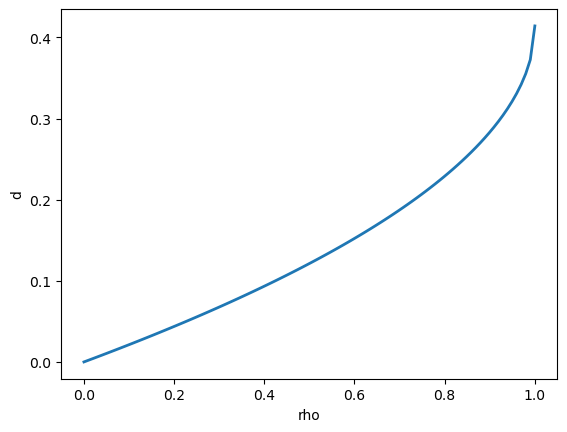

In [6]:
rho = np.linspace(0, 1, 100)
d = [getLeftRoot(-(np.sqrt(2)+1)**2, 2*(np.sqrt(2)+1), -1*i) for i in rho]
fig, ax = plt.subplots()
ax.set_xlabel('rho')
ax.set_ylabel('d')
ax.plot(rho, d, linewidth=2.0)

plt.show()

#### the calculation of effective properties matrix CH

##### voxel method (low)

In [7]:
from numpy import linalg as LA
# 149 lines with 3d
def generate_voxel(n, rho):
    d = getLeftRoot(-(np.sqrt(2)+1)**2, 2*(np.sqrt(2)+1), -1*rho)
    x = np.zeros((n,n))
    dx = 1./n
    # coors of vertex
    node = np.array([[0,0],[1,0],[1,1],[0,1]])
    # truss node
    strut = [[0,1],
            [1,2],
            [2,3],
            [3,0],
            [0,2],
            [1,3]]
    for i in range(n):
        for j in range(n):
            center = [dx/2+ i*dx, dx/2+j*dx]
            for k in range(len(strut)):
                start_n = node[strut[k][0]]
                end_n = node[strut[k][1]]

                distance = LA.norm(np.cross(end_n-start_n, center-start_n))/LA.norm(end_n-start_n)
                if distance <= d:
                    x[i,j] = 1
                    continue
    return x


##### voxel method with geoProjection (high)

In [8]:
def generate_voxel_geoProjection(n, rho):
    d = getLeftRoot(-(np.sqrt(2)+1)**2, 2*(np.sqrt(2)+1), -1*rho)
    x = np.zeros((n,n))
    dx = 1./n
    r = np.sqrt(2)/2 * dx
    p = 10
    rho_min = 1e-4

    # coors of vertex
    node = np.array([[0,0],[1,0],[1,1],[0,1]])
    # truss node
    strut = [[0,1],
            [1,2],
            [2,3],
            [3,0],
            [0,2],
            [1,3]]

    rho_strut = np.zeros((len(strut),n,n))

    for i in range(n):
        for j in range(n):
            center = [dx/2+ i*dx, dx/2+j*dx]
            for k in range(len(strut)):
                start_n = node[strut[k][0]]
                end_n = node[strut[k][1]]

                distance = LA.norm(np.cross(end_n-start_n, center-start_n))/LA.norm(end_n-start_n) # dq
                phi_q = distance - d/2
                if phi_q > r:
                    rho_strut[k,i,j] = 0
                elif phi_q < -1 *r:
                    rho_strut[k,i,j] = 1
                else:
                    rho_strut[k,i,j] = 1/(np.pi * np.power(r,2)) * \
                            (np.power(r,2)*np.arccos(phi_q/r) - phi_q * np.sqrt(np.power(r,2)-np.power(phi_q,2)))
                
                rho_strut[k,i,j] = rho_min + rho_strut[k,i,j] * (1 - rho_min)

            x[i,j] = np.min((LA.norm(rho_strut[:,i,j], np.inf),1))
        
    return x

In [9]:
from scipy import io

def saveMat(filename, n, rhoList):
    res = np.zeros((len(rhoList), n, n))
    for i in range(len(rhoList)):
        res[i] = generate_voxel_geoProjection(n, rhoList[i])
    io.savemat(filename, {'x_list':res})


In [11]:
rho_list = np.linspace(0.,1,100)
saveMat('crossed_20x20_100.mat',20, rho_list)


In [11]:
y=io.loadmat('10x10_100_CH.mat')
y['CH'][33]


array([[ 2.38306271e+00,  7.61704414e-01, -2.49095449e-16],
       [ 7.61704414e-01,  2.38306271e+00, -7.21536546e-17],
       [-1.69894480e-16, -4.14707331e-17,  9.72211685e-01]])